In [1]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

import sys
np.set_printoptions(threshold=sys.maxsize)

from src.turn_db_main_into_utility_matrix import from_mongo_collection_to_utility_matrix

In [2]:
utility_to_song, utility_to_artist, df = from_mongo_collection_to_utility_matrix(db.main_redo)

Madlib is the producer with the most samples, with James Brown sampled.
1484 is the most sampled artist, sampled 625 times.


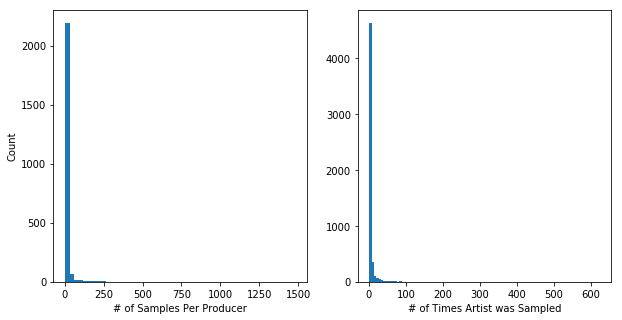

In [99]:
producers = utility_to_artist.sum(axis =0)
sampled_artists = utility_to_artist.sum(axis =1)

prod_with_most_samples = utility_to_artist.sum(axis = 0).idxmax()
most_sampled_artist = utility_to_artist.sum(axis = 1).idxmax()
most_samples = utility_to_artist.sum(axis = 0).max()
times_sampled = utility_to_artist.sum(axis = 1).max()

print(
"{} is the producer with the most samples, with {} sampled.\n\
{} is the most sampled artist, sampled {} times.".format(
        prod_with_most_samples, most_sampled_artist, most_samples, times_sampled))

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].set(xlabel = "# of Samples Per Producer", ylabel = "Count")
_ = ax[0].hist(producers, bins = 50)

# ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
ax[1].set(xlabel = "# of Times Artist was Sampled")
_ = ax[1].hist(sampled_artists, bins = 100)

In [94]:
utility_to_artist.sum(axis = 0).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

,Count
new_song_producer,
Madlib,1484
9th Wonder,1122
The Alchemist,939
DJ Paul,930
DJ Premier,859
Juicy J,815
Kanye West,640
Knxwledge.,588
Prince Paul,542


In [93]:
utility_to_artist.sum(axis = 1).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

#These results are shocking- Three 6 Mafia?

#I checked and they are right- three 6 gets sampled a lot.

,Count
sampled_artist,
James Brown,625
Three 6 Mafia,251
The Notorious B.I.G.,229
Public Enemy,224
Jay-Z,204
Kool & the Gang,191
Isaac Hayes,184
Michael Jackson,145
Eric B. & Rakim,141


In [3]:
# How sparse is matrix?
 
matrix_size = utility_to_artist.shape[0]*utility_to_artist.shape[1] # Number of possible interactions in the matrix
nonzeros = sum(utility_to_artist.sum(axis=0))
sparsity = 100*(1 - (nonzeros/matrix_size))
print([nonzeros, matrix_size, sparsity])

#We have a matrix that is 99.8% sparse. Kind of a problem. According to https://jessesw.com/Rec-System/ 
# maximum is 99.5%

#If we go by artist, we get down to 99.765%

[28327, 12502547, 99.7734301658694]



There are 15809 unique records. There are 1324 producers. There are 7789 songs sampled.

In [5]:
from src.first_recommender_using_implict import get_model_and_user_items_from_utility_matrix
model, user_items = get_model_and_user_items_from_utility_matrix(utility_to_artist)

100%|██████████| 100.0/100 [00:05<00:00, 17.27it/s, loss=0.000814]


In [13]:
#What's up with Kanye?
print(utility_to_artist.loc["James Brown","Kanye West"])

#Actually, there is a 3 for Otis Redding- 
#is that because Kanye sampled him three times?

#An 11 for James Brown! Wow.

sum(utility_to_song.loc[:,"Kanye West"])
#Apparently he sampled 640 artists, also 640 songs.

11


640

In [9]:
model.recommend(1000, user_items)

[(1328, 0.038173527),
 (2577, 0.03122052),
 (5320, 0.030238453),
 (3846, 0.028904708),
 (3464, 0.027546264),
 (4200, 0.02601924),
 (3479, 0.022954363),
 (568, 0.022596516),
 (2036, 0.022526186),
 (1767, 0.019638106)]

In [10]:
model.similar_items(itemid = 2009)

[(1338, 0.08010418),
 (5, 0.08010418),
 (764, 0.08010418),
 (2916, 0.08010418),
 (2933, 0.08010418),
 (736, 0.08010418),
 (2469, 0.08010418),
 (2446, 0.08010418),
 (2342, 0.08010418),
 (1062, 0.08010418)]

In [ ]:
#Settings from https://jessesw.com/Rec-System/
# He says these are best

alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

In [ ]:
from ItemItemRecommender import ItemItemRecommender
recommend = ItemItemRecommender()
recommend.fit(data_sparse)


In [127]:
recomenders_for_4th_Disciple = recommend.pred_one_user(11)

In [137]:
ind = np.argwhere(recomenders_for_4th_Disciple)
data.columns[ind]

Index(['It's a New Day', 'Change the Beat (Female Version)', 'Rubber Jam',
       'Makin' Believe That It's You', 'In the Rain', 'Midnight Theme',
       'The Epic of Bitter Triumph', 'N.T.',
       'Love Theme From "Romeo and Juliet" (A Time for Us)', 'Do It Again',
       ...
       'Think Big', 'The Eye of a Needle', 'One Less Bell to Answer',
       'Don't Say Goodnight (It's Time for Love) (Parts 1 & 2)',
       'The Tragedy (Don't Do It)', 'Ain't No Half Steppin'',
       'Kool It (Here Comes the Fuzz)', 'Trilogy of Terror', 'L Dopa',
       'Do It Your Way'],
      dtype='object', length=1011)

In [ ]:
import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random

from sklearn.preprocessing import MinMaxScaler

import implicit

# Create a numeric user_id and artist_id column
data['user'] = data['user'].astype("category")
data['artist'] = data['artist'].astype("category")
data['user_id'] = data['user'].cat.codes
data['artist_id'] = data['artist'].cat.codes

# The implicit library expects data as a item-user matrix so we
# create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)
sparse_item_user = sparse.csr_matrix((data['plays'].astype(float), (data['artist_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['plays'].astype(float), (data['user_id'], data['artist_id'])))

# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)


#---------------------
# FIND SIMILAR ITEMS
#---------------------

# Find the 10 most similar to Jay-Z
item_id = 147068 #Jay-Z
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

# Print the names of our most similar artists
for item in similar:
    idx, score = item
    print data.artist.loc[data.artist_id == idx].iloc[0]

    
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 2025
user_id = 2025

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

artists = []
scores = []

# Get artist names from ids
for item in recommended:
    idx, score = item
    artists.append(data.artist.loc[data.artist_id == idx].iloc[0])
    scores.append(score)

# Create a dataframe of artist names and scores
recommendations = pd.DataFrame({'artist': artists, 'score': scores})

print recommendations
